In [1]:
# Import all dependencies
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
# add the SVM module
from sklearn import svm
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(10))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # ---------------------- Added Features ---------------------- #
    # remove HTML tags from reviews
    movie_data['review'] = movie_data['review'].str.replace(r'<[^<>]*>', '', regex=True)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
        
    # ---------------------- Added Features ---------------------- #
    
    X_quant_features = movie_data[["word_count", "punc_count"]]

    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

### Create training and test sets from function 
Test set is using 25

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# testing set uses 25: 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/moviereviews_train.tsv', my_random_seed=25)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
        id  sentiment                                             review
0   5814_8          1  With all this stuff going down at the moment w...
1   2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2   7759_3          0  The film starts with a manager (Nicholas Bell)...
3   3630_4          0  It must be assumed that those who praised this...
4   9495_8          1  Superbly trashy and wondrously unpretentious 8...
5   8196_8          1  I dont know why people think this is such a ba...
6   7166_2          0  This movie could have been very good, but come...
7  10633_1          0  I watched this video at a friend's house. I'm ...
8    319_1          0  A friend of mine bought this film for £1, and ...
9  8713_10  

### Fit (and tune) Various Models

#### MODEL: Ridge Regression Classifier

##### default

In [5]:
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


##### alpha=1000

In [6]:
rdg1000 = linear_model.RidgeClassifier(alpha=1000)
rdg1000.fit(X_train, y_train)

rdg1000_performance_train = BinaryClassificationPerformance(rdg1000.predict(X_train), y_train, 'rdg_train1000')
rdg1000_performance_train.compute_measures()
print(rdg1000_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train1000'}


##### alpha=10000000

In [7]:
rdg10000000 = linear_model.RidgeClassifier(alpha=10000000)
rdg10000000.fit(X_train, y_train)

rdg10000000_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train10000000')
rdg10000000_performance_train.compute_measures()
print(rdg10000000_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8363, 'TN': 9879, 'FP': 144, 'FN': 1614, 'Accuracy': 0.9121, 'Precision': 0.9830727636064418, 'Recall': 0.8382279242257191, 'desc': 'rdg_train10000000'}


##### solver='sag'

In [8]:
rdg_sag = linear_model.RidgeClassifier(solver='sag')
rdg_sag.fit(X_train, y_train)

rdg_sag_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train_sag')
rdg_sag_performance_train.compute_measures()
print(rdg_sag_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8363, 'TN': 9879, 'FP': 144, 'FN': 1614, 'Accuracy': 0.9121, 'Precision': 0.9830727636064418, 'Recall': 0.8382279242257191, 'desc': 'rdg_train_sag'}


##### random_state=1000

In [9]:
rdg_random_state = linear_model.RidgeClassifier(random_state=1000)
rdg_random_state.fit(X_train, y_train)

rdg_random_state_performance_train = BinaryClassificationPerformance(rdg10000000.predict(X_train), y_train, 'rdg_train_random-state')
rdg_random_state_performance_train.compute_measures()
print(rdg_random_state_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8363, 'TN': 9879, 'FP': 144, 'FN': 1614, 'Accuracy': 0.9121, 'Precision': 0.9830727636064418, 'Recall': 0.8382279242257191, 'desc': 'rdg_train_random-state'}


##### random_state=1000, alpha=10000000

In [10]:
rdg_alpha_random = linear_model.RidgeClassifier(random_state=1000, alpha=10000000)
rdg_alpha_random.fit(X_train, y_train)

rdg_alpha_random_performance_train = BinaryClassificationPerformance(rdg_alpha_random.predict(X_train), y_train, 
                                                                     'rdg_train_alpha-random')
rdg_alpha_random_performance_train.compute_measures()
print(rdg_alpha_random_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 8361, 'TN': 9880, 'FP': 143, 'FN': 1616, 'Accuracy': 0.91205, 'Precision': 0.9831843838193791, 'Recall': 0.8380274631652801, 'desc': 'rdg_train_alpha-random'}


##### random_state=1000, alpha=1000

In [11]:

rdg_alpha_random_2 = linear_model.RidgeClassifier(random_state=1000, alpha=1000)
rdg_alpha_random_2.fit(X_train, y_train)

rdg_alpha_random_2_performance_train = BinaryClassificationPerformance(rdg_alpha_random_2.predict(X_train), y_train, 
                                                                     'rdg_train_alpha-random-2')
rdg_alpha_random_2_performance_train.compute_measures()
print(rdg_alpha_random_2_performance_train.performance_measures)




{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train_alpha-random-2'}


# Linear SVC

##### default

In [12]:
# LinearSVC
linear_SVC_default = svm.LinearSVC()
linear_SVC_default.fit(X_train, y_train)

linear_SVC_default_performance_train = BinaryClassificationPerformance(linear_SVC_default.predict(X_train), y_train, 
                                                               'linear_SVC_default_train')
linear_SVC_default_performance_train.compute_measures()
print(linear_SVC_default_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_default_train'}


##### C=1000000

In [13]:
# LinearSVC
linear_SVC_1m = svm.LinearSVC(C=1000000)
linear_SVC_1m.fit(X_train, y_train)

linear_SVC_1m_performance_train = BinaryClassificationPerformance(linear_SVC_1m.predict(X_train), y_train, 
                                                               'linear_SVC_1m_train')
linear_SVC_1m_performance_train.compute_measures()
print(linear_SVC_1m_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_1m_train'}


##### C=0.001

In [14]:
# LinearSVC
linear_SVC_001 = svm.LinearSVC(C=0.001)
linear_SVC_001.fit(X_train, y_train)

linear_SVC_001_performance_train = BinaryClassificationPerformance(linear_SVC_001.predict(X_train), y_train, 
                                                               'linear_SVC_001_train')
linear_SVC_001_performance_train.compute_measures()
print(linear_SVC_001_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 9977, 'TN': 10023, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'linear_SVC_001_train'}


##### C=1e-15

In [15]:
# LinearSVC
linear_SVC_1e15 = svm.LinearSVC(C=1e-15)
linear_SVC_1e15.fit(X_train, y_train)

linear_SVC_1e15_performance_train = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_train), y_train, 
                                                               'linear_SVC_1e15_train')
linear_SVC_1e15_performance_train.compute_measures()
print(linear_SVC_1e15_performance_train.performance_measures)

{'Pos': 9977, 'Neg': 10023, 'TP': 8567, 'TN': 9816, 'FP': 207, 'FN': 1410, 'Accuracy': 0.91915, 'Precision': 0.9764075678139958, 'Recall': 0.8586749523904982, 'desc': 'linear_SVC_1e15_train'}


### ROC plot to compare performance of various models and fits - TRAIN set

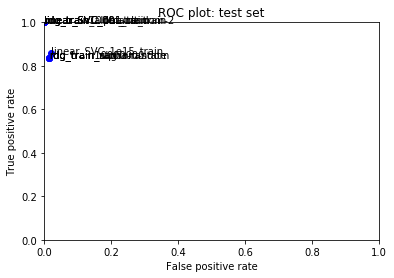

In [16]:
fits = [rdg_performance_train, rdg1000_performance_train, rdg10000000_performance_train, 
        rdg_sag_performance_train, rdg_random_state_performance_train,
        rdg_alpha_random_performance_train, rdg_alpha_random_2_performance_train,
       linear_SVC_default_performance_train, linear_SVC_1m_performance_train, 
        linear_SVC_001_performance_train, linear_SVC_1e15_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Look at performance on the test set

#### MODEL: Ridge Regression Classifier

##### default

In [17]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2182, 'TN': 2062, 'FP': 415, 'FN': 341, 'Accuracy': 0.8488, 'Precision': 0.8402002310358105, 'Recall': 0.8648434403487911, 'desc': 'rdg_test'}


##### alpha=1000

In [18]:
rdg1000_performance_test = BinaryClassificationPerformance(rdg1000.predict(X_test), y_test, 'rdg_test_1000')
rdg1000_performance_test.compute_measures()
print(rdg1000_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2203, 'TN': 2083, 'FP': 394, 'FN': 320, 'Accuracy': 0.8572, 'Precision': 0.8482864844050828, 'Recall': 0.8731668648434403, 'desc': 'rdg_test_1000'}


##### alpha=10000000

In [19]:
rdg10000000_performance_test = BinaryClassificationPerformance(rdg10000000.predict(X_test), y_test, 'rdg_test_10000000')
rdg10000000_performance_test.compute_measures()
print(rdg10000000_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 1787, 'TN': 2328, 'FP': 149, 'FN': 736, 'Accuracy': 0.823, 'Precision': 0.9230371900826446, 'Recall': 0.7082837891399129, 'desc': 'rdg_test_10000000'}


##### random_state=1000

In [20]:
rdg_random_state_performance_test = BinaryClassificationPerformance(rdg_random_state.predict(X_test), y_test, 'rdg_test_random-state')
rdg_random_state_performance_test.compute_measures()
print(rdg_random_state_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2061, 'FP': 416, 'FN': 343, 'Accuracy': 0.8482, 'Precision': 0.8397534668721109, 'Recall': 0.8640507332540627, 'desc': 'rdg_test_random-state'}


##### random_state=1000, alpha=10000000

In [21]:
rdg_alpha_random_performance_test = BinaryClassificationPerformance(rdg_alpha_random.predict(X_test), y_test, 
                                                                    'rdg_test_alpha-random')
rdg_alpha_random_performance_test.compute_measures()
print(rdg_alpha_random_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 1787, 'TN': 2328, 'FP': 149, 'FN': 736, 'Accuracy': 0.823, 'Precision': 0.9230371900826446, 'Recall': 0.7082837891399129, 'desc': 'rdg_test_alpha-random'}


##### random_state=1000, alpha=1000


In [22]:
rdg_alpha_random_2_performance_test = BinaryClassificationPerformance(rdg_alpha_random_2.predict(X_test), y_test, 
                                                                    'rdg_test_alpha-random-2')
rdg_alpha_random_2_performance_test.compute_measures()
print(rdg_alpha_random_2_performance_test.performance_measures)




{'Pos': 2523, 'Neg': 2477, 'TP': 2202, 'TN': 2084, 'FP': 393, 'FN': 321, 'Accuracy': 0.8572, 'Precision': 0.8485549132947977, 'Recall': 0.8727705112960761, 'desc': 'rdg_test_alpha-random-2'}


# Linear SVC

##### default

In [23]:
linear_SVC_default_performance_test = BinaryClassificationPerformance(linear_SVC_default.predict(X_test), y_test, 
                                                              'linear_SVC_default_test')
linear_SVC_default_performance_test.compute_measures()
print(linear_SVC_default_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_default_test'}


##### C=1000000

In [24]:
linear_SVC_1m_performance_test = BinaryClassificationPerformance(linear_SVC_1m.predict(X_test), y_test, 
                                                              'linear_SVC_1m_test')
linear_SVC_1m_performance_test.compute_measures()
print(linear_SVC_1m_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2213, 'TN': 2098, 'FP': 379, 'FN': 310, 'Accuracy': 0.8622, 'Precision': 0.8537808641975309, 'Recall': 0.8771304003170829, 'desc': 'linear_SVC_1m_test'}


##### C=001

In [25]:
linear_SVC_001_performance_test = BinaryClassificationPerformance(linear_SVC_001.predict(X_test), y_test, 
                                                              'linear_SVC_001_test')
linear_SVC_001_performance_test.compute_measures()
print(linear_SVC_001_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 2218, 'TN': 2115, 'FP': 362, 'FN': 305, 'Accuracy': 0.8666, 'Precision': 0.8596899224806202, 'Recall': 0.8791121680539041, 'desc': 'linear_SVC_001_test'}


##### C=1e-15

In [26]:
linear_SVC_1e15_performance_test = BinaryClassificationPerformance(linear_SVC_1e15.predict(X_test), y_test, 
                                                              'linear_SVC_1e15_test')
linear_SVC_1e15_performance_test.compute_measures()
print(linear_SVC_1e15_performance_test.performance_measures)

{'Pos': 2523, 'Neg': 2477, 'TP': 1878, 'TN': 2311, 'FP': 166, 'FN': 645, 'Accuracy': 0.8378, 'Precision': 0.9187866927592955, 'Recall': 0.7443519619500595, 'desc': 'linear_SVC_1e15_test'}


### ROC plot to compare performance of various models and fits - TEST set

{'Pos': 2523, 'Neg': 2477, 'TP': 2182, 'TN': 2062, 'FP': 415, 'FN': 341, 'Accuracy': 0.8488, 'Precision': 0.8402002310358105, 'Recall': 0.8648434403487911, 'desc': 'rdg_test'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2203, 'TN': 2083, 'FP': 394, 'FN': 320, 'Accuracy': 0.8572, 'Precision': 0.8482864844050828, 'Recall': 0.8731668648434403, 'desc': 'rdg_test_1000'}
{'Pos': 2523, 'Neg': 2477, 'TP': 1787, 'TN': 2328, 'FP': 149, 'FN': 736, 'Accuracy': 0.823, 'Precision': 0.9230371900826446, 'Recall': 0.7082837891399129, 'desc': 'rdg_test_10000000'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2180, 'TN': 2061, 'FP': 416, 'FN': 343, 'Accuracy': 0.8482, 'Precision': 0.8397534668721109, 'Recall': 0.8640507332540627, 'desc': 'rdg_test_random-state'}
{'Pos': 2523, 'Neg': 2477, 'TP': 1787, 'TN': 2328, 'FP': 149, 'FN': 736, 'Accuracy': 0.823, 'Precision': 0.9230371900826446, 'Recall': 0.7082837891399129, 'desc': 'rdg_test_alpha-random'}
{'Pos': 2523, 'Neg': 2477, 'TP': 2202, 'TN': 2084, 'FP': 393, 'FN': 321, 'Accuracy

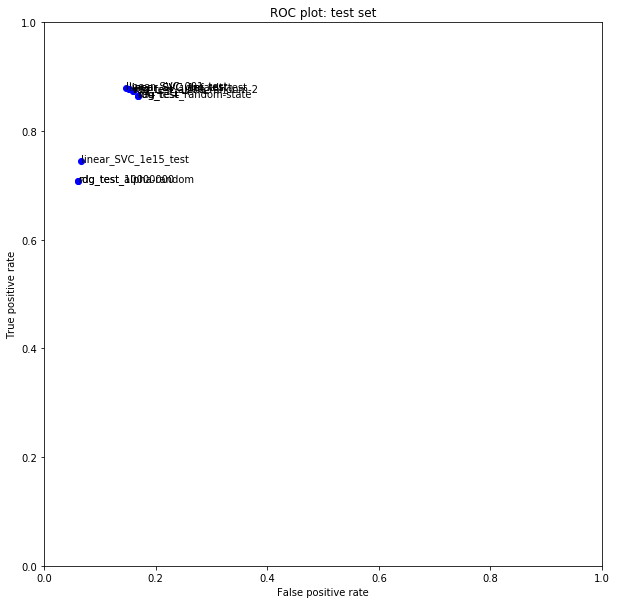

In [27]:
fits = [rdg_performance_test, rdg1000_performance_test, rdg10000000_performance_test, 
        rdg_random_state_performance_test, rdg_alpha_random_performance_test, rdg_alpha_random_2_performance_test,
       linear_SVC_default_performance_test, linear_SVC_1m_performance_test, linear_SVC_001_performance_test, 
        linear_SVC_1e15_performance_test]

plt.figure(figsize=(10,10))

for fit in fits:
    print(fit.performance_measures)
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
